In [1]:
import geopandas as gpd
import rasterio as rio
import rasterio.plot
import pandas as pd
import os
import re
import rapidfuzz
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 130)

In [2]:
df = gpd.read_file("shorelines.geojson")
df = df.dissolve(by="filename").reset_index()
df

,filename,geometry,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,Uncertaint,UNCY,Length,Photoscale,Pixel_ER,Georef_ER,Dig_ER,Total_UNCY,Date_,OBJECTID,Shape_Leng,SN,SourceFile,Year_,Month_,Day_,Date2,Shape_Le_1,DSAS_NZDAT,OBJECTID_1
0,Auckland/BrownsBay/Shorelines/BrownsBay_20MAR1988.shp,"MULTILINESTRING ((174.75123 -36.71079, 174.75107 -36.71093, 174.75071 -36.71128, 174.75049 -36.71147, 174.75039 -36.71163, 174...",0,Auckland,BrownsBay,1988-03-20,None,MT,1000,Very difficult to identify cliff top,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
1,Auckland/KarekareBethells/Shorelines/KarekareBethells_02JAN2004.shp,"MULTILINESTRING ((174.44669 -36.89126, 174.44625 -36.89155, 174.44576 -36.89177, 174.44510 -36.89201, 174.44477 -36.89212, 174...",0,Auckland,Bethells Beach,2004-01-02,None,MW,2000,tod,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
2,Auckland/KarekareBethells/Shorelines/KarekareBethells_09AUG1955.shp,"MULTILINESTRING ((174.44900 -36.90415, 174.44900 -36.90427, 174.44893 -36.90433, 174.44887 -36.90440, 174.44898 -36.90446, 174...",0,Auckland,Wigmore Bay,1955-08-09,None,MW,3000,tod,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
3,Auckland/KarekareBethells/Shorelines/KarekareBethells_14APR1940.shp,"MULTILINESTRING ((174.44434 -36.89390, 174.44438 -36.89398, 174.44447 -36.89405, 174.44453 -36.89413, 174.44464 -36.89422, 174...",0,Auckland,Bethells Beach,1940-04-14,None,MW,2000,"Northern end of beach missing from mosaic, Difficult to distinguish toe of dune",RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
4,Auckland/KarekareBethells/Shorelines/KarekareBethells_19AUG1960.shp,"MULTILINESTRING ((174.46894 -36.95319, 174.46885 -36.95313, 174.46862 -36.95313, 174.46849 -36.95304, 174.46838 -36.95294, 174...",0,Auckland,Piha Beach (north),1960-08-19,None,Mw,2000,tod,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,WestCoast/WhareateaRiver/Shorelines/WhareateaRiver_15JAN1988.shp,"MULTILINESTRING ((171.67547 -41.73801, 171.67541 -41.73795, 171.67527 -41.73789, 171.67521 -41.73785, 171.67516 -41.73777, 171...",0,WestCoast,WhareateaRiver,1988-01-15,None,ER,1000,None,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
834,WestCoast/WhareateaRiver/Shorelines/WhareateaRiver_25NOV1974.shp,"MULTILINESTRING ((171.71569 -41.72124, 171.71545 -41.72114, 171.71528 -41.72091, 171.71528 -41.72070, 171.71522 -41.72043, 171...",0,WestCoast,WhareateaRiver,1974-11-25,None,ER,2000,None,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
835,WestCoast/WoodpeckerBay/Shorelines/WoodpeckerBay_17APR1976_mosaic.shp,"MULTILINESTRING ((171.40552 -41.98601, 171.40564 -41.98604, 171.40568 -41.98608, 171.40567 -41.98615, 171.40566 -41.98622, 171...",0,WestCoast,WoodpeckerBay,1976-04-17,None,MD,1000,Edge Veg,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
836,WestCoast/WoodpeckerBay/Shorelines/WoodpeckerBay_18FEB1988_mosaic.shp,"LINESTRING (171.40564 -41.98606, 171.40563 -41.98623, 171.40568 -41.98630, 171.40562 -41.98634, 171.40559 -41.98639, 171.40569...",0,WestCoast,WoodpeckerBay,1988-02-18,None,MD,1000,Edge Veg,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN


In [3]:
probably_retrolens = df.Date < "2000"
print(probably_retrolens.value_counts())
df = df[probably_retrolens]

True     575
False    263
Name: Date, dtype: int64


In [4]:
strings_to_delete = ["_mosaic", "_mosiac", "_mosaid", "_cliff", "_beach", "_beachcliffsegment", "_MF", "_MT"]

def fuzz_preprocess(filename):
    for s in strings_to_delete:
        filename = filename.replace(s, "")
    # Case-insensitive
    filename = filename.lower()
    # Ignore extension
    filename = os.path.splitext(filename)[0]
    return filename

def get_matching_image(filename):
    filename = "/mnt/coastal_raw/" + filename.replace("Stack", "").replace("Shorelines", "Stack")
    dirname = os.path.dirname(filename)
    filename = os.path.basename(filename)
    all_files_in_folder = sorted([f for f in os.listdir(dirname) if os.path.splitext(f)[1] in [".jpg", ".jp2", ".tif"]])
    match, score, index = rapidfuzz.process.extractOne(query=filename, choices=all_files_in_folder, processor=fuzz_preprocess)
    if score < 70:
        print(match, score)
        print(filename)
        print(all_files_in_folder)
    full_match_path = os.path.join(dirname, match)
    return match, score, full_match_path

df["matched_image"], df["match_score"], df["full_match_path"] = zip(*df.filename.apply(get_matching_image))
print(sum(df.match_score == 100))
print(sum(df.match_score < 100))
df[["filename", "matched_image", "match_score"]].sort_values(by="match_score").to_csv("shoreline_image_matching.csv", index=False)

TiwaiPoint_01MAR1962_mosaic.jp2 65.11627906976744
TiwaiPoint_RL_11FEB1978.shp
['TiwaiPoint_01MAR1962_mosaic.jp2', 'TiwaiPoint_15MAR1951_mosaic.jp2', 'TiwaiPoint_28NOV1998_mosaic.jp2']
TiwaiPoint_01MAR1962_mosaic.jp2 69.76744186046511
TiwaiPoint_RL_12FEB1969.shp
['TiwaiPoint_01MAR1962_mosaic.jp2', 'TiwaiPoint_15MAR1951_mosaic.jp2', 'TiwaiPoint_28NOV1998_mosaic.jp2']
TiwaiPoint_15MAR1951_mosaic.jp2 69.76744186046511
TiwaiPoint_RL_17OCT1985.shp
['TiwaiPoint_01MAR1962_mosaic.jp2', 'TiwaiPoint_15MAR1951_mosaic.jp2', 'TiwaiPoint_28NOV1998_mosaic.jp2']
516
59


/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [5]:
# Get a random (known-good) annotation
sample = df[df.match_score == 100].sample(1)
sample

,filename,geometry,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,Uncertaint,UNCY,Length,Photoscale,Pixel_ER,Georef_ER,Dig_ER,Total_UNCY,Date_,OBJECTID,Shape_Leng,SN,SourceFile,Year_,Month_,Day_,Date2,Shape_Le_1,DSAS_NZDAT,OBJECTID_1,matched_image,match_score,full_match_path
111,Bay of Plenty/PukehinaBeach/Shorelines/PukehinaBeach_19MAR1986.shp,"MULTILINESTRING ((176.58745 -37.82225, 176.58714 -37.82204, 176.58663 -37.82179, 176.58631 -37.82167, 176.58605 -37.82146, 176...",0,Bay of Plenty,PukehinaBeach,1986-03-19,None,ER,1000,None,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN,PukehinaBeach_19MAR1986_mosaic.jp2,100.0,/mnt/coastal_raw/Bay of Plenty/PukehinaBeach/Stack/PukehinaBeach_19MAR1986_mosaic.jp2


In [6]:
image_filepath = sample.full_match_path.iloc[0]
image_filepath

'/mnt/coastal_raw/Bay of Plenty/PukehinaBeach/Stack/PukehinaBeach_19MAR1986_mosaic.jp2'

In [7]:
image = rio.open(image_filepath)
image

<open DatasetReader name='/mnt/coastal_raw/Bay of Plenty/PukehinaBeach/Stack/PukehinaBeach_19MAR1986_mosaic.jp2' mode='r'>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


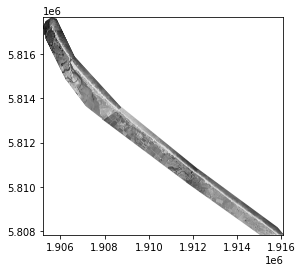

<AxesSubplot:>

In [8]:
rasterio.plot.show(image)